## StatQuest!
# XGBoost in Python, From Start to Finish (Heart Disease)
Copyright 2020, Joshua Starmer

----

In this lesson we will use **XGBoost** to build a collection of boosted trees (one of which is illustrated below), and use continuous and categorical data from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)** to predict whether or not a patient has **[heart disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**.

<!-- <img src="./xgboost_tree.png" alt="An XGBoost Tree" style="width: 600px;"> -->
<img src="./xgboost_tree.png" alt="An XGBoost Tree">

**XGBoost** is an exceptionally useful machine learning method when you don't want to sacrifice the ability to correctly classify observations but you still want a model that is fairly easy to understand and interpret. 

In this lesson you will learn about...

- **[Importing Data from a File](#download-the-data)**

- **[Missing Data](#identify-and-deal-with-missing-data)**
    - Identifying Missing Data
    - Dealing with Missing Data
    

- **[Formatting the Data for XGBoost](#format-the-data)**

    - Splitting data into Dependent and Independent Variables
    - One-Hot-Encoding
    - Converting all columns to Int, Float or Bool
    

- **[Building a Preliminary XGBoost Model](#build-tree)**


- **[Optimizing Parameters with Cross Validation and GridSearch()](#optimize-parameters)**
    
    - Optimizing the learning rate, tree depth, number of trees, gamma (for pruning) and lambda (for regularization).


- **[Building, Drawing, Interpreting and Evaluating the Optimized XGBoost Model](#draw-tree)**

#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and are familiar with the theory behind **[XGBoost](https://youtu.be/OtD8wVaFm6E)**, **[Cross Validation](https://youtu.be/fSytzGwwBVw)** and **[Confusion Matrices](https://youtu.be/Kdsp6soqA7o)**. If not, check out the **StatQuests** by clicking on the links for each topic.


#### Also Note:
I strongly encourage you to play around with the code. Playing with the code is the best way to learn from it.

-----

# Import the modules that will do all the work
The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the **XGBoost** model. 

**NOTE:** You will need **Python 3** and have at least these versions for each of the following modules: 
- pandas >= 1.2.3
- numpy >= 1.19.2
- sklearn >= 0.24.1
- xgboost >= 1.3.3
 
If you installed **Python 3** with [Anaconda](https://www.anaconda.com/), you can check which versions you have with the command: `conda list`. If, for example, your version of `scikit-learn` is older than 0.22.1, then the easiest thing to do is just update all of your **Anaconda** packages with the following command: `conda update --all`. However, if you only want to update `scikit-learn`, then you can run this command: `conda install scikit-learn=0.22.1`.

If you need to install `xgboost`, then you can do so with the following command: `conda install -c conda-forge xgboost`.

**NOTE:** To draw the tree, you will also need to install `graphviz`. You can do that with the command: `conda install graphviz python-graphviz`.

In [1]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

----

<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**. This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

**NOTE:** When **pandas** (**pd**) reads in data, it returns a **data frame**, which is a lot like a spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable name for a **data frame** is the initials **df**, and that is what we will use here:

In [2]:
df = pd.read_csv('processed.cleveland.data', 
                 header=None)

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We see that instead of nice column names, we just have column numbers.  Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [4]:
# change the column names

df.columns = ['age', 
              'sex', 
              'cp', 
              'restbp', 
              'chol', 
              'fbs', 
              'restecg', 
              'thalach', 
              'exang', 
              'oldpeak', 
              'slope', 
              'ca', 
              'thal', 
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      303 non-null    float64
 1   sex      303 non-null    float64
 2   cp       303 non-null    float64
 3   restbp   303 non-null    float64
 4   chol     303 non-null    float64
 5   fbs      303 non-null    float64
 6   restecg  303 non-null    float64
 7   thalach  303 non-null    float64
 8   exang    303 non-null    float64
 9   oldpeak  303 non-null    float64
 10  slope    303 non-null    float64
 11  ca       303 non-null    object 
 12  thal     303 non-null    object 
 13  hd       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


Hooray! We have replaced the column numbers with nice, easy to remember names. Now that we have the data in a **data frame** called **df**, we are ready to identify and deal with **Missing Data**.



----

<a id="identify-and-deal-with-missing-data"></a>
# Missing Data Part 1: Identifying Missing Data

Unfortunately, the biggest part of any data analysis project is making sure that the data is correctly formatted and fixing it when it is not. The first part of this process is identifying **Missing Data**.

**Missing Data** is simply a blank space, or a surrogate value like **NA**, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

One thing that is relatively unique about **XGBoost** is that it has default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

In this section, we'll focus on identifying missing values in the dataset. 

First, let's see what sort of data is in each column.

In [6]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

We see that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.

The fact that the **ca** and **thal** columns have `object` data types suggests there is something funny going on in them. `object` datatypes are used when there are mixtures of things, like a mixture of numbers and letters. In theory, both **ca** and **thal** should just have a few values representing different categories, so let's investigate what's going on by printing out their unique values. We'll start with **ca**:

In [7]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [8]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, **thal** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

Now that we have identified some missing values, we need to deal with them.


----


# Missing Data Part 2: Dealing With Missing Data, XGBoost Style

One thing that is relatively unique about **XGBoost** is that it determines default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

However, before we do that, let's see how many rows are missing data. If it's a lot, then we might have a problem on our hands that is bigger than what **XGBoost** can deal with on its own. If it's not that many, we can just set them to `0`.

In [9]:
len(df.loc[(df['ca'] == '?') 
           | 
           (df['thal'] == '?')])

6

Since only 6 rows have missing values, let's look at them.

In [10]:
df.loc[(df['ca'] == '?') 
       | 
       (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Now let's count the number of rows in the full dataset.

In [11]:
len(df)

303

So 6 of the **303** rows, or **2%**, contain missing values. So let's just set the missing values, `?`, to `0` and be done with this problem.

In [12]:
df.loc[(df['ca'] == '?'), 'ca'] = 0
df.loc[(df['thal'] == '?'), 'thal'] = 0

We can  make sure **ca** no longer contains question marks by printing its unique values:

In [13]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', 0], dtype=object)

And we can also do the same thing for **thal**:

In [14]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', 0], dtype=object)

**BAM!!!** We have verified that `df` contains `0`s instead of `?`s for missing values. **NOTE:** **ca** and **thal** still have the `object` data type. That's no good, but we can deal with that later.

----

<a id="format-the-data"></a>
# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making an **XGBoost** model.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **hd** (heart disease).

The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and  remove the missing values etc.

In [15]:
X = df.drop('hd', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [16]:
y = df['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready ton continue formatting **X** so that it is suitable for making a model with **XGBoost**.

----

<a id="one-hot-encoding"></a>
# Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina
  - 2 = atypical angina
  - 3 = non-anginal pain
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)

Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

In [17]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

So, we see that **age**, **restbp**, **chol** and **thalach** are all `float64`, which is good, because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasonable values, and some of them need to change. This is because, while **XGBoost** natively supports continuous data, like resting blood pressure (**restbp**) and maximum heart rate (**thalach**), it does not natively support categorical data, like chest pain (**cp**), which contains 4 different categories. Thus, in order to use categorical data with **XGBoost**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **cp** (chest pain) column, we have 4 options:
1. typical angina
2. atypical angina
3. non-anginal pain
4. asymptomatic

If we treated these values, 1, 2, 3 and 4, like continuous data, then we would assume that 4, which means "asymptomatic", is more similar to 3, which means "non-anginal pain", than it is to 1 or 2, which are other types of chest pain. That means the **XGBoost Tree** would be more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering patients with 4s with 3s is the same as clustering 4s with 1s, and that approach is more reasonable.

Now let's inspect and, if needed, convert the columns that contain categorical and integer data into the correct datatypes. We'll start with **cp** (chest pain) by inspecting all of its unique values:
<!-- We'll start with the three colunms that should only contain 0s and 1s. **sex**. First, let's make sure it only contains `0` (for **female**) and `1` (for **male**). -->

In [18]:
X['cp'].unique()

array([1., 4., 3., 2.])

So, the good news is that **cp** only contains the values it is supposed to contain, so we will convert it, using **One-Hot Encoding**, into a series of columns that only contains **0s** and **1s**.

<!-- Now we need to deal with **cp** (chest pain), **restecg** (resting electrocardiographic results), **slope** (the slope of the peak exercise ST segment) and **thal** (thalium heart scan).
 -->
**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **XGBoost** model using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **XGBoost** model is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and loses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`. However, once you are comfortable with **One-Hot Encoding**, I encourage you to investigate using `ColumnTransformer()`.

First, before we commit to converting **cp** with **One-Hot Encoding**, let's just see what happens when we convert **cp** without saving the results. This will make it easy to see how `get_dummies()` works.

In [19]:
pd.get_dummies(X, columns=['cp']).head()

# In Pandas, we only have 4 data type: 1. Object (str or mixed) 2. int 64 3. float64 4. bool

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process in the front and it puts **cp** at the end. It also splits **cp** into **4** columns, just like we expected it. **cp_1.0** is `1` for any patient that scored a **1** for chest pain and `0` for all other patients. **cp_2.0** is `1` for any patient that scored **2** for chest pain and `0` for all other patients. **cp_3.0** is `1` for any patient that scored **3** for chest pain and **cp_4.0** is `1` for any patient that scored **4** for chest pain.

Now that we see how `get_dummies()` works, let's use it on the four categorical columns that have more than 2 categories and save the result.

**NOTE:** In a real situation (not a tutorial like this), you should verify all 5 of these columns to make sure they 
only contain the accepted categories. However, for this tutorial, I've already done that for us, so we can skip that step.

In [20]:
X_encoded = pd.get_dummies(X, columns=['cp', 
                                       'restecg', 
                                       'slope', 
                                       'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,1,0,0,1,0,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,0,0,1,0,1,0,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,0,0,1,0,1,0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,1,0,0,0,0,1,0,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,1,1,0,0,0,1,0,0


# BAM!!!
Now we need to talk about the **3** categorical columns that only contain **0**s and **1**s: **sex**, **fbs** (fasting blood sugar), and **exang** (exercise induced angina). As we can see, **One-Hot Encoding** converts a column with more than **2** categories, like **cp** (chest pain) into multiple columns of **0**s and **1**s. Since **sex**, **fbs**, and **exang** only have **2** categories and only contain **0**s and **1**s to begin with, we do not have to do anything special to them, so we're done formatting the data for the **XGBoost** model.

**NOTE:** In practice we would use `unique()` to verify that they only contain **0**s and **1**s, but to save time...trust me!

Now, one last thing before we build an **XGBoost** model.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [21]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

Since we're only making an **XGBoost** model that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [22]:
y_not_zero_index = y > 0
y[y_not_zero_index] = 1
y.unique()

array([0, 1], dtype=int64)

-----

<a id="one-hot-encoding"></a>
# Format the Data Part 3: Convert all columns to Int, Float or Bool

**XGBoost** requires that all data be either `int`, `float` or `boolean` data types. We can use `dtypes` to see if there are any columns that need to be converted...

In [23]:
X_encoded.dtypes

age            float64
sex            float64
restbp         float64
chol           float64
fbs            float64
thalach        float64
exang          float64
oldpeak        float64
ca              object
cp_1.0           uint8
cp_2.0           uint8
cp_3.0           uint8
cp_4.0           uint8
restecg_0.0      uint8
restecg_1.0      uint8
restecg_2.0      uint8
slope_1.0        uint8
slope_2.0        uint8
slope_3.0        uint8
thal_0           uint8
thal_3.0         uint8
thal_6.0         uint8
thal_7.0         uint8
dtype: object

...and we see we need to convert the column **ca** to a `float` or `integer`. We do this with the pandas function `to_numeric()`.

In [24]:
X_encoded['ca'] = pd.to_numeric(X_encoded['ca'])
X_encoded.dtypes

age            float64
sex            float64
restbp         float64
chol           float64
fbs            float64
thalach        float64
exang          float64
oldpeak        float64
ca             float64
cp_1.0           uint8
cp_2.0           uint8
cp_3.0           uint8
cp_4.0           uint8
restecg_0.0      uint8
restecg_1.0      uint8
restecg_2.0      uint8
slope_1.0        uint8
slope_2.0        uint8
slope_3.0        uint8
thal_0           uint8
thal_3.0         uint8
thal_6.0         uint8
thal_7.0         uint8
dtype: object

Now let's double check `y` and make sure it is either `float`, `int` or `boolean`.

In [25]:
y.dtypes

dtype('int64')

# Double BAM!!!

We have finally finished formatting the data for making an **XGBoost** model, so let's do it!!!



----

<a id="build-tree"></a>
# Build A Preliminary XGBoost Model
At long last, the data is correctly formatted for making an **XGBoost** model. Now we simply split the data into **training** and **testing** sets and build the model.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric="logloss", ## this avoids a warning...
                            seed=42, 
                            use_label_encoder=False)

## NOTE: newer versions of XGBoost will issue a warning if you don't explitly tell it that
## you are not expecting it to do label encoding on its own (in other words, since we
## have ensured that the categorical values are all numeric, we do not expect XGBoost to do label encoding), 
## so we set use_label_encoder=False

clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

OK, we've built an **XGBoost** model for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

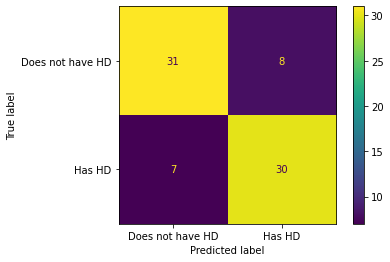

In [27]:
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

<!-- NOTE: because we included the missing data, we get different training/testing dataset from SVM and classification trees, so we get different results etc.
 -->

We can see it is actually balanced dataset
 
In the confusion matrix, we see that of the **31 + 8 = 39** people that did not have **Heart Disease**, **31 (79%)** were correctly classified. And of the **7 + 30 = 37** people that have **Heart Disease**, **30 (81%)** were correctly classified. Can we do better? One thing that might be holding this **XGBoost** back is that we have not tried to tune any of its many parameters. So let's optimize the parameters and see if we can improve classification.

----

<a id="optimize-parameters"></a>
# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manual configure and are not determined by XGBoost itself, including `n_estimators`, the number of **XGBoost Trees** to make, `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, and `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [28]:
## NOTE: This code takes a few minutes to run, so I've commented it out.
## Since I set seed=42, we'll get the same results anyway, and those are
## coded into the next section...

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'n_estimators': range(50, 250, 50),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 100.0]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric="logloss", seed=42, use_label_encoder=False),
    param_grid=param_grid,
    scoring = 'roc_auc',## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'reg_lambda': 10.0}


So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=1`, `learn_rate=0.1`, `max_depth=3`, `n_estimators=200` and `reg_lambda=100`.

----

<a id="draw-tree"></a>
# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [29]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="logloss", ## this avoids a warning...
                        gamma=1,
                        learning_rate=0.1,
                        max_depth=3,
                        n_estimators=200,
                        reg_lambda=10,
                        use_label_encoder=False)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

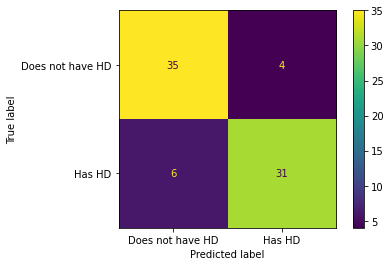

In [30]:
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

We see that the optimized **XGBoost** model is...only a little better at classifying people that do not have heart disease and a little worse at classifying people that have it. This is a little bit of a bummer, but this is a relatively small dataset for **XGBoost**, which is designed for **BIG DATA**, data that is in the gigabyte range. We use a small dataset for this tutorial because we want to spend our time going through each step of the process, rather than spending all day fitting the model.

Of the **35 + 4 = 39** people that did not have heart disease, **35 (90%)** were correctly classified. This is an improvement over the preliminary model, which only correctly classified **33 (85%)** of the patients without heart disease. Of the **6 + 31 = 37** people with heart disease, **31 (85%)** were correctly classified. This is slightly worse than the preliminary model, which correctly classified **32 (86%)** of the patients with heart disease.

The last thing we are going to do is draw the first **XGBoost Tree** and discuss how to interpret it.

In [31]:
## If we want to get information, like gain and cover etc, at each node in the first tree, 
## we just build the first tree, otherwise we'll get the average over all of the trees.
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            eval_metric="logloss", ## this avoids a warning...
                            gamma=1,
                            learning_rate=0.1,
                            max_depth=3,
                            n_estimators=1, ## We set this to 1 so we can get gain, cover etc.
                            reg_lambda=10,
                            use_label_encoder=False)
clf_xgb.fit(X_train, y_train)

## now print out the weight, gain, cover etc. for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average gain across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover = the total coverage across all splits the feature is used in
## NOTE: Since we only built one tree, gain = total_gain and cover=total_cover
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
## NOTE: num_trees is NOT the number of trees to plot, but the specific tree you want to plot
## The default value is 0, but I'm setting it just to show it in action since it is
## counter-intuitive.
xgb.to_graphviz(clf_xgb, num_trees=0, size="1,1", 
                condition_node_params=node_params,
                leaf_node_params=leaf_params) 
## if you want to save the figure...
graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", 
                condition_node_params=node_params,
                 leaf_node_params=leaf_params) 
graph_data.view(filename='xgboost_tree') ## save as PDF

weight:  {'restbp': 1.0, 'oldpeak': 1.0, 'ca': 1.0, 'cp_4.0': 1.0, 'slope_3.0': 1.0, 'thal_7.0': 1.0}
gain:  {'restbp': 4.634284973144531, 'oldpeak': 5.521223068237305, 'ca': 10.161581039428711, 'cp_4.0': 41.92176055908203, 'slope_3.0': 1.1938250064849854, 'thal_7.0': 5.640179634094238}
cover:  {'restbp': 27.5, 'oldpeak': 30.75, 'ca': 26.0, 'cp_4.0': 56.75, 'slope_3.0': 3.25, 'thal_7.0': 11.75}
total_gain:  {'restbp': 4.634284973144531, 'oldpeak': 5.521223068237305, 'ca': 10.161581039428711, 'cp_4.0': 41.92176055908203, 'slope_3.0': 1.1938250064849854, 'thal_7.0': 5.640179634094238}
total_cover:  {'restbp': 27.5, 'oldpeak': 30.75, 'ca': 26.0, 'cp_4.0': 56.75, 'slope_3.0': 3.25, 'thal_7.0': 11.75}


'xgboost_tree.pdf'

Now let's discuss how to interpret the **XGBoost Tree**.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **cp_4.0** to split the observations. All observations with **cp_4.0 < 1** go to the **left** and all observations with **cp_4.0 =< 1** go to the **right**.
- Each branch either says **yes** or **no** and some also say **missing**. 
 - **yes** and **no** refer to whether the threshold in the node above it is true or not. If so, then **yes**, if not, then **no**. 
 - **missing** is the default option if there is missing data.
- **leaf** tells us the output value for each leaf.

-----

# In conclusion we...

- **[Loaded the Data From a File](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Formatted the Data for XGBoost using One-Hot Encoding](#one-hot-encoding)**

- **[Built an XGBoost Model for Classification](#build-tree)**

- **[Optimize the XGBoost Parameters with Cross Validation and GridSearch()](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Optimized XGBoost Model](#draw-tree)**

# TRIPLE BAM!!!